# Permeability upscaling for the Darcy problem

We present how to perform a permeability upscaling by using the multi-point flux approximation (MPFA) of the Darcy equation.

We want to solve the following problems for each subdomains
\begin{gather*}
   \begin{cases}
      -\nabla\cdot\left(\nabla {K} p^H\right) = 0\qquad \text{in}\,V \\
      p^H(0,y) = L_1                                                     \\
      p^H(L_1,y) = 0                                                     \\
      \nabla p^H\cdot {n}=0 \qquad \text{on},(x,0)\bigcup(x,L_2)
   \end{cases}
   \qquad
   \begin{cases}
      -\nabla\cdot\left(\nabla {K} p^V\right) = 0\qquad \text{in}\,V \\
      p^V(x,0) = L_2                                                     \\
      p^V(x,L_2) = 0                                                     \\
      \nabla p^V\cdot {n}=0 \qquad \text{on},(0,y)\bigcup(L_1,y)
   \end{cases}
\end{gather*}

The upscaled permeability is then computed by solving the following system
\begin{gather*}
   \left[\begin{array}{ccccc}
         <\nabla p^H>_x & <\nabla p^H>_y & 0              & 0              \\
         0              & 0              & <\nabla p^H>_x & <\nabla p^H>_y \\
         <\nabla p^V>_x & <\nabla p^V>_y & 0              & 0              \\
         0              & 0              & <\nabla p^V>_x & <\nabla p^V>_y \\
      \end{array} \right]\left[\begin{array}{c}K^\star_{xx} \\ K^\star_{xy}\\K^\star_{yx}\\
         K^\star_{yy}\end{array}\right]=-\left[\begin{array}{c}<{q}^H>_x \\<{q}^H>_y\\
         <{q}^V>_x    \\<{q}^V>_y\end{array}\right].
\end{gather*}
with $<\cdot>$ is the average operator.

First we import some of the standard modules.

In [1]:
import time
start_time = time.time()

import numpy as np
import porepy as pp
import scipy.sparse as sps
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import ray
import scipy.sparse.linalg as spsla


/home/dave/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


Depending on the setting, we then need to setup the local path for importing some useful functions

In [3]:
import sys
main_folder = "./"
spe10_folder = main_folder + "spe10"
sys.path.insert(1, spe10_folder)

#from functions import *
from spe10 import Spe10
from access_solve import *



Define the function that given a subdomain, its data, and a direction compute the upscaled gradient and flux.

In [82]:
def upscale(sd, perm, dir, export_folder=None):
    """
    Compute the averaged gradient and flux for a given subdomain and direction of the pressure
    gradient.

    Args:
        sd (pp.Grid): The grid representing the subdomain.
        perm (dict): The permeability of the subdomain divided in the fields "kxx" and "kyy"
        dir (int): The direction of the flow, 0 means x-direction and 1 means y-direction.
        export_folder (str): If given, path where to export the results.
            Default to None, no exporting.

    Returns:
        (np.ndarray, np.ndarray): averaged gradient and flux.
    """
    # Permeability
    perm_tensor = pp.SecondOrderTensor(kxx=perm["kxx"], kyy=perm["kyy"])

    # Boundary conditions
    b_faces = sd.tags["domain_boundary_faces"].nonzero()[0]
    b_face_centers = sd.face_centers[:, b_faces]

    # Find the min and max values of the boundary faces
    sd_min = np.amin(sd.face_centers[dir, :])
    sd_max = np.amax(sd.face_centers[dir, :])

    # define outflow and inflow type boundary conditions
    out_flow = np.isclose(b_face_centers[dir, :], sd_max)
    in_flow = np.isclose(b_face_centers[dir, :], sd_min)

    # define the labels and values for the boundary faces
    labels = np.array(["neu"] * b_faces.size)
    labels[np.logical_or(in_flow, out_flow)] = "dir"

    bc_val = np.zeros(sd.num_faces)
    bc_val[b_faces[in_flow]] = sd_max - sd_min

    bc = pp.BoundaryCondition(sd, b_faces, labels)

    # Collect all parameters in a dictionary
    key = "flow"
    parameters = {"second_order_tensor": perm_tensor, "bc": bc, "bc_values": bc_val}
    data = pp.initialize_default_data(sd, {}, key, parameters)

    ###############################################################################################################

    # Discretize the problem (construct the lhr and rhs)
    discr = pp.Mpfa(key)
    discr.discretize(sd, data)

    A, b = discr.assemble_matrix_rhs(sd, data)

    # Solve the linear system and compute the pressure
    # Solve the linear system using Conjugate Gradient (CG) method
    p, info = spsla.cg(A, b)
    ###############################################################################################################

    # Export the solution
    if export_folder is not None:
        save = pp.Exporter(sd, "sol", folder_name=export_folder)
        save.write_vtu([("p", p), ("log_perm", np.log10(perm["kxx"]))])

    # Post-process the solution to get the flux
    return compute_avg_q_grad(sd, p, data, key, bc, bc_val)

In [83]:
def compute_tensor(grad_h, grad_v, q_h, q_v):
    """
    Compute the upscaled permeability tensor.

    Args:
        grad_h (np.ndarray): Gradient in the horizontal direction.
        grad_v (np.ndarray): Gradient in the vertical direction.
        q_h (np.ndarray): Flux in the horizontal direction.
        q_v (np.ndarray): Flux in the vertical direction.

    Returns:
        perm (np.ndarray): Upscaled permeability tensor.

    The function solves a linear system to obtain the upscaled permeability tensor
    based on the given gradients and fluxes. It enforces numerical symmetry and
    checks if the resulting tensor is symmetric positive definite (SPD).
    """
    
    ## Assembling spd matrix for least squares
    A = np.array([[grad_h[0], grad_h[1], 0, 0],
                  [0, 0, grad_h[0], grad_h[1]],
                  [grad_v[0], grad_v[1], 0, 0],
                  [0, 0, grad_v[0], grad_v[1]],
                  [0, 1, -1,0]])
    b = np.array([q_h[0], q_h[1], q_v[0], q_v[1],0])
    
    # Solve the linear system
    K_avg = np.linalg.lstsq(A, b,rcond = None)[0]

    perm = nearest_spd(K_avg.reshape(2, 2)).ravel()
    
    return perm

Define the function that compute the symmetric upscaled tensor.

In [84]:

def Checkpoint1_solution(selected_layers, folder_results, quads):

    # Read the SPE10 grid
    spe10 = Spe10(selected_layers)

    # Read the permeability associated to the given layer(s)
    perm_folder = spe10_folder + "/perm/"
    spe10.read_perm(perm_folder)
    perm_dict = spe10.perm_as_dict()

    # Partition the grid
    num_part = quads
    part, sub_sds, sd_coarse = coarse_grid(spe10.sd, num_part)
    ray.shutdown()
    ray.shutdown()
    ray.init()

    
    result = []
    args = [(sub_sd_id, sub_sd, perm_dict, part) for sub_sd_id, sub_sd in enumerate(sub_sds)]

    @ray.remote
    def to_parallel_ray(sub_sd_id, sub_sd, perm_dict, part):
        return to_parallel(sub_sd_id, sub_sd, perm_dict, part)

    # Submit tasks to ray
    result = ray.get([to_parallel_ray.remote(*arg) for arg in args])

    # Shutdown ray
    ray.shutdown()


    return sd_coarse, result

In [85]:
def solve_coarse(
    sd,
    pos_well,
    kk,
    injection_rate=1,
    well_pressure=0,
    export_folder=None, dimension = 100
):
    """
    Compute the averaged gradient and flux for a given subdomain and direction of the pressure
    gradient.

    Args:
        spe10 (object): The object representing the subdomain.
        pos_well (np.ndarray): The position of the production well.
        injection_rate (float, optional): The injection rate of the wells. Defaults to 1.
        well_pressure (float, optional): The pressure at the production well. Defaults to 0.
        export_folder (str, optional): If given, path where to export the results. Defaults to
            None.

    Returns:
        float: The maximum pressure at the injection wells.
    """
    
    # Extract the grid for simplicity
    kxx = np.zeros([dimension])
    kxy = np.zeros([dimension])
    kyy = np.zeros([dimension])

    i = 0
    for elem in kk:
        kxx[i] = elem[0]
        kxy[i] = elem[1]
        kyy[i] = elem[3]
        i = i + 1

    # Permeability
    perm_tensor = pp.SecondOrderTensor(kxx=kxx, kxy=kxy, kyy=kyy)
    
     
    full_shape_0 = sd.full_shape[0]
    full_shape_1 = sd.full_shape[1]
    spacing = sd.spacing

    # Boundary conditions
    b_faces = sd.tags["domain_boundary_faces"].nonzero()[0]

    # Define the labels and values for the boundary faces
    labels = np.array(["neu"] * b_faces.size)
    bc_val = np.zeros(sd.num_faces)
    bc = pp.BoundaryCondition(sd, b_faces, labels)

    # Collect all parameters in a dictionary
    key = "flow"
    parameters = {"second_order_tensor": perm_tensor, "bc": bc, "bc_values": bc_val}
    data = pp.initialize_default_data(sd, {}, key, parameters)

    # Discretize the problem
    discr = pp.Mpfa(key)
    discr.discretize(sd, data)

    A, b = discr.assemble_matrix_rhs(sd, data)

    # Add the injection wells, all with the same injection rate
    b_wells = np.zeros_like(b)
    index_iwells = [
        0,
        full_shape_0 - 1,
        full_shape_0 * full_shape_1 - full_shape_0,
        full_shape_0 * full_shape_1 - 1,
    ]
    b_wells[index_iwells] = injection_rate

    # Add the production well by using a Lagrange multiplier, first we identify the cell
    ij_well = np.floor((np.asarray(pos_well) / spacing)).astype(int)
    # print(ij_well)
    index_pwell = full_shape_0 * ij_well[1] + ij_well[0]
    vect = np.zeros((sd.num_cells, 1))
    vect[index_pwell] = 1

    # Solve the linear system and compute the pressure by adding the constraint
    A = sps.bmat([[A, vect], [vect.T, None]], format="csc")
    b = np.append(b + b_wells, well_pressure)
    p = sps.linalg.spsolve(A, b)[:-1]
    

    # extract the discretization matrices build 
    mat_discr = data[pp.DISCRETIZATION_MATRICES][key]

    # reconstruct the flux as post-process
    q_tpfa = mat_discr["flux"] @ p + mat_discr["bound_flux"] @ bc_val

    # to export the flux                                                                                                   
    mvem = pp.MVEM(key)                                                                                      
    mvem.discretize(sd, data)                                                                                                                                                                                     
    # construct the P0 flux reconstruction                                                                                 
    cell_q_mpfa = mvem.project_flux(sd, q_tpfa, data) 


    # Export the solution
    if export_folder is not None:
        save = pp.Exporter(sd, "sol", folder_name=export_folder)
        # save.write_vtu([("p", p), ("log_kxx", np.log10(perm_dict["kxx"])),("q_mpfa", cell_q_mpfa)])
        save.write_vtu([("p", p), ("log_kxx", np.log10(kk[:,0])),("q_mpfa", cell_q_mpfa)])         

        # Return the maximum pressure at the injection wells
    return np.max(p[index_iwells])

Perform the upscaling for the Spe10 benchmark of a given layer.

In [86]:
def to_parallel(sub_sd_id, sub_sd, perm_dict, part):
    mask = part == sub_sd_id
    sub_perm = {key: val[mask] for key, val in perm_dict.items()}
    ##local compute gradients and velcities for the choses (sub_sd_id) quad
    q_h, grad_h = upscale(sub_sd, sub_perm, 0, None)
    q_v, grad_v = upscale(sub_sd, sub_perm, 1, None)

    return compute_tensor(grad_h, grad_v, q_h, q_v)

In [87]:
def solve_coarse_wrapper(i, j, sd_coarse, x, result, export_folder, dimension):
    return (solve_coarse(sd_coarse, x, result, export_folder=export_folder, dimension = dimension), i, j)



In [88]:
def checkpoint2_solution(selected_layers, folder_results):

    # Read the SPE10 grid
    spe10 = Spe10(selected_layers)
    perm_folder = spe10_folder + "/perm/"
    spe10.read_perm(perm_folder)
    perm_dict = spe10.perm_as_dict()

    block_width_100 = sd_coarse_100.spacing[0]
    block_height_100 = sd_coarse_100.spacing[1]

    block_width_400 = sd_coarse_400.spacing[0]
    block_height_400 = sd_coarse_400.spacing[1]
    ray.shutdown()

    ray.init()


    # computation on coarse scale
    coarse_pressures_100=[]
    arguments = [ (i, j, sd_coarse_100, [i, j], result_100, folder_results, 100) for i in np.arange(0.5*block_width_100, spe10.full_physdims[0], block_width_100) for j in np.arange(0.5*block_height_100, spe10.full_physdims[1], block_height_100)] 

    @ray.remote
    def solve_coarse_wrapper_ray(*arg):
        return solve_coarse_wrapper(*arg)

    # Submit tasks to ray
    coarse_pressures_100 = ray.get([solve_coarse_wrapper_ray.remote(*arg) for arg in arguments])    
    # Shutdown ray

   

    # computation on coarse scale
    coarse_pressures_400=[]
    arguments = [ (i, j, sd_coarse_400, [i, j], result_400, folder_results, 400) for i in np.arange(0.5*block_width_400, spe10.full_physdims[0], block_width_400) for j in np.arange(0.5*block_height_400, spe10.full_physdims[1], block_height_400)] 

    # Submit tasks to ray
    coarse_pressures_400 = ray.get([solve_coarse_wrapper_ray.remote(*arg) for arg in arguments])

    # Shutdown ray
    ray.shutdown()

    coarse_pressures_100.sort(key=lambda x: x[0])
    #print(coarse_pressures_100)
    coarse_pressures_100 = coarse_pressures_100[:12]

    coarse_pressures_400.sort(key=lambda x: x[0])
    #print(coarse_pressures_400)
    coarse_pressures_400 = coarse_pressures_400[:35]


    x_values_100 = [x for _, x, _ in coarse_pressures_100]
    y_values_100 = [y for _, _, y in coarse_pressures_100]

    # Extracting (x, y) coordinates
    coordinates = np.array([(x, y) for _, x, y in coarse_pressures_100])

    # Set the minimum distance threshold
    min_distance = 67  # Adjust as needed

    # DBSCAN clustering
    dbscan = DBSCAN(eps=min_distance, min_samples=1)  # min_samples determines the minimum number of points in a cluster
    cluster_labels = dbscan.fit_predict(coordinates)

    # Creating dictionary to store clusters
    clusters = {}
    for label in set(cluster_labels):
        clusters[label] = [coarse_pressures_100[i] for i, l in enumerate(cluster_labels) if l == label]

    # Printing the clusters
    for cluster_id, cluster in clusters.items():
        print(f"Cluster {cluster_id}:")
        for item in cluster:
            print(item)
        print()

    # Plotting the clusters
    plt.figure(figsize=(10, 6))

    # Plotting each cluster
    for label in set(cluster_labels):
        if label == -1:
            # Points labeled as -1 are outliers, plotting them separately
            outliers_x = [x_values_100[i] for i, l in enumerate(cluster_labels) if l == label]
            outliers_y = [y_values_100[i] for i, l in enumerate(cluster_labels) if l == label]
            plt.scatter(outliers_x, outliers_y, color='gray', label='Outliers')
        else:
            cluster_x = [x_values_100[i] for i, l in enumerate(cluster_labels) if l == label]
            cluster_y = [y_values_100[i] for i, l in enumerate(cluster_labels) if l == label]
            plt.scatter(cluster_x, cluster_y, label=f'Cluster {label}')

    # Plotting the domain boundaries
    plt.xlim(0, 365)
    plt.ylim(0, 670)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('DBSCAN Clustering')

    plt.legend()
    plt.grid(True)
    plt.show()


    x_values = [x for _, x, _ in coarse_pressures_400]
    y_values = [y for _, _, y in coarse_pressures_400]

    # Extracting (x, y) coordinates
    coordinates = np.array([(x, y) for _, x, y in coarse_pressures_400])

    # Set the minimum distance threshold
    min_distance = 33  # Adjust as needed

    # DBSCAN clustering
    dbscan = DBSCAN(eps=min_distance, min_samples=1)  # min_samples determines the minimum number of points in a cluster
    cluster_labels_refined = dbscan.fit_predict(coordinates)

    # Creating dictionary to store clusters
    clusters_refined = {}
    for label in set(cluster_labels_refined):
        clusters_refined[label] = [coarse_pressures_400[i] for i, l in enumerate(cluster_labels_refined) if l == label]

    # Printing the clusters
    for cluster_id, cluster in clusters_refined.items():
        print(f"Cluster refined {cluster_id}:")
        for item in cluster:
            print(item)
        print()

    # Plotting the clusters
    plt.figure(figsize=(10, 6))

    # Plotting each cluster
    for label in set(cluster_labels_refined):
        if label == -1:
            # Points labeled as -1 are outliers, plotting them separately
            outliers_x = [x_values[i] for i, l in enumerate(cluster_labels_refined) if l == label]
            outliers_y = [y_values[i] for i, l in enumerate(cluster_labels_refined) if l == label]
            plt.scatter(outliers_x, outliers_y, color='gray', label='Outliers')
        else:
            cluster_x = [x_values[i] for i, l in enumerate(cluster_labels_refined) if l == label]
            cluster_y = [y_values[i] for i, l in enumerate(cluster_labels_refined) if l == label]
            plt.scatter(cluster_x, cluster_y, label=f'Cluster refined{label}')

    # Plotting the domain boundaries
    plt.xlim(0, 365)
    plt.ylim(0, 670)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('DBSCAN Clustering')

    plt.legend()
    plt.grid(True)
    plt.show()

    selected_clusters = []

    # Iterate through refined clusters
    for refined_cluster_id, refined_cluster in clusters_refined.items():
        refined_cluster_coordinates = [(x, y) for _, x, y in refined_cluster]
        
        # Check if any refined cluster coordinate falls within the larger clusters
        for label, coarse_cluster in clusters.items():
            X, Y = coarse_cluster[0][1], coarse_cluster[0][2]  # Assuming the center coordinates of the coarse cluster
            dx = sd_coarse_100.spacing[0]
            dy = sd_coarse_100.spacing[1]
            
            # Check if any refined cluster coordinate falls within the boundaries of the coarse cluster
            if any((X - dx <= x <= X + dx) and (Y - dy <= y <= Y + dy) for x, y in refined_cluster_coordinates):
                selected_clusters.append(refined_cluster)
                break  # Stop checking for this refined cluster if it's already found in a larger cluster

    # Print the selected refined clusters
    for i, refined_cluster in enumerate(selected_clusters, 1):
        print(f"Selected Refined Cluster {i}:")
        for item in refined_cluster:
            print(item)
        print()

    # Plotting the clusters
    plt.figure(figsize=(10, 6))

    # Plotting each coarse cluster
    for label, coarse_cluster in clusters.items():
        coarse_cluster_x = [x for _, x, _ in coarse_cluster]
        coarse_cluster_y = [y for _, _, y in coarse_cluster]
        plt.scatter(coarse_cluster_x, coarse_cluster_y, label=f'Coarse Cluster {label}')

    # Plotting each selected refined cluster
    for i, selected_refined_cluster in enumerate(selected_clusters, 1):
        refined_cluster_x = [x for _, x, _ in selected_refined_cluster]
        refined_cluster_y = [y for _, _, y in selected_refined_cluster]
        plt.scatter(refined_cluster_x, refined_cluster_y, label=f'Selected Refined Cluster {i}', marker='x', color='red')

    # Plotting the domain boundaries
    plt.xlim(0, 365)
    plt.ylim(0, 670)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Clusters and Selected Refined Clusters')

    plt.legend()
    plt.grid(True)
    plt.show()

    # Initialize a list to store tuples (p, x, y)
    clusters_data = []

    # Iterate over each cluster in selected_refined_clusters
    for cluster in selected_clusters:
        # Iterate over each point in the cluster
        for p, x, y in cluster:
            # Append the tuple (p, x, y) to the list
            clusters_data.append((p, x, y))

    # Print or process the list of tuples (p, x, y)
    print("List of tuples (p, x, y) for selected_refined_clusters:")
    for data in clusters_data:
        print(data)


    ray.init()
    @ray.remote
    def solve_fine_wrapper_ray(*arg):
        return [solve_fine_wrapper(*arg)]  
    coord = [[x, y] for _, x, y in clusters_data]
    arguments = [(c[0], c[1], spe10, [c[0], c[1]], 1, 0, None) for c in coord] 
    fine_evaluation = ray.get([solve_fine_wrapper_ray.remote(*arg) for arg in arguments])  

    # Shutdown Ray

    fine_evaluation.sort(key=lambda x: x[0])

    #print(fine_evaluation)

    best = [fine_evaluation[0][0][1], fine_evaluation[0][0][2]]


    print("best coarse is", best)




    i_range = (0, 365.76)
    j_range = (0, 670.56)

    arguments = [(i, j, spe10, [i, j], 1, 0, None) 
                for i in np.arange(best[0] - 6 * 6.096, best[0] + 6 * 6.096, 6.096) 
                for j in np.arange(best[1] - 6 * 3.048, best[1] + 6 * 3.048, 3.048)
                if i_range[0] <= i <= i_range[1] and j_range[0] <= j <= j_range[1]]
    
    main_evaluation = ray.get([solve_fine_wrapper_ray.remote(*arg) for arg in arguments])

    main_evaluation.sort(key=lambda x: x[0])

    best = [main_evaluation[0][0][1], main_evaluation[0][0][2]]

    print("best fine is", best)

    ray.shutdown()

    #Evaluate angles        

    angle_vertex = [(0, 0), (365.76 - 2*sd_coarse_100.spacing[0], 0), (0, 670.56 - sd_coarse_100.spacing[1]), (365.76 - 2*sd_coarse_100.spacing[0], 670.56 - sd_coarse_100.spacing[1])]
    _, index = solve_fine(spe10, best, export_folder=folder_results)
    angle_width=2*sd_coarse_100.spacing[0]
    angle_height=sd_coarse_100.spacing[1]

    initial_point = angle_vertex[index]


    arguments = [(i, j, spe10, [i, j], 1, 0, None) 
                for i in np.arange(initial_point[0] + (6.096 / 2), initial_point[0] + angle_width, 3*6.096) 
                for j in np.arange(initial_point[1] + (3.048 / 2), initial_point[1] + angle_height, 3*3.048)
                if i_range[0] <= i <= i_range[1] and j_range[0] <= j <= j_range[1]]
    
    angle_evaluation = ray.get([solve_fine_wrapper_ray.remote(*arg) for arg in arguments])

    ray.shutdown()
    
    angle_evaluation.sort(key=lambda x: x[0])

    best_angle = [angle_evaluation[0][0][1], angle_evaluation[0][0][2]]

    print("best angle is", best_angle)

    if(angle_evaluation[0][0][0] < main_evaluation[0][0][0]):
        best = best_angle

 
    return best

2024-05-28 17:16:45,832	INFO worker.py:1749 -- Started a local Ray instance.
2024-05-28 17:17:34,432	INFO worker.py:1749 -- Started a local Ray instance.
2024-05-28 17:19:56,610	INFO worker.py:1749 -- Started a local Ray instance.


Cluster 0:
(5.040398457913966, 237.74400000000006, 100.584)
(5.042410932807809, 201.16800000000006, 100.584)
(5.046631010997487, 164.59200000000004, 100.584)

Cluster 1:
(5.0419223698299955, 274.32000000000005, 33.528)
(5.042023791818626, 237.74400000000006, 33.528)
(5.053767322081809, 201.16800000000006, 33.528)

Cluster 2:
(5.051068917072721, 201.16800000000006, 167.64000000000001)
(5.05230759638182, 237.74400000000006, 167.64000000000001)
(5.0540905947587005, 164.59200000000004, 167.64000000000001)
(5.059059331809473, 128.01600000000002, 167.64000000000001)

Cluster 3:
(5.059624619457991, 201.16800000000006, 234.69600000000003)
(5.059707897030547, 164.59200000000004, 234.69600000000003)



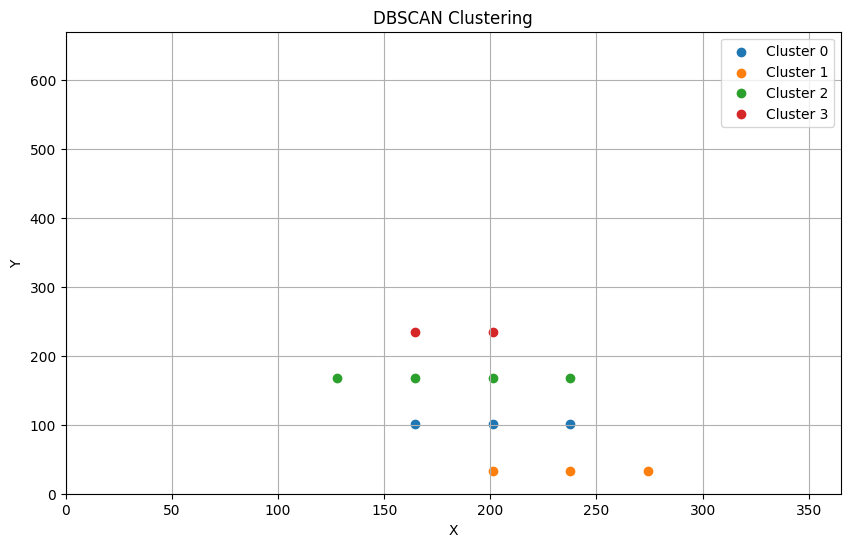

Cluster refined 0:
(8.930687841141244, 246.88800000000006, 50.292)
(8.930920487955017, 228.60000000000005, 50.292)
(8.933015177042625, 265.17600000000004, 50.292)
(8.933278016462625, 210.31200000000004, 50.292)
(8.934902505720084, 283.46400000000006, 50.292)
(8.947650672680025, 192.02400000000006, 50.292)

Cluster refined 1:
(8.933639809995055, 246.88800000000006, 16.764)
(8.934490213883535, 265.17600000000004, 16.764)
(8.936837582761962, 283.46400000000006, 16.764)
(8.937668464641087, 301.75200000000007, 16.764)
(8.938657291453264, 228.60000000000005, 16.764)

Cluster refined 2:
(8.933872956997904, 210.31200000000004, 83.82000000000001)
(8.934549248226707, 228.60000000000005, 83.82000000000001)
(8.94213894193528, 192.02400000000006, 83.82000000000001)

Cluster refined 3:
(8.938498548612978, 210.31200000000004, 117.34800000000001)
(8.939073436524053, 228.60000000000005, 117.34800000000001)
(8.939776305069302, 192.02400000000006, 117.34800000000001)
(8.941839726099872, 173.7360000000000

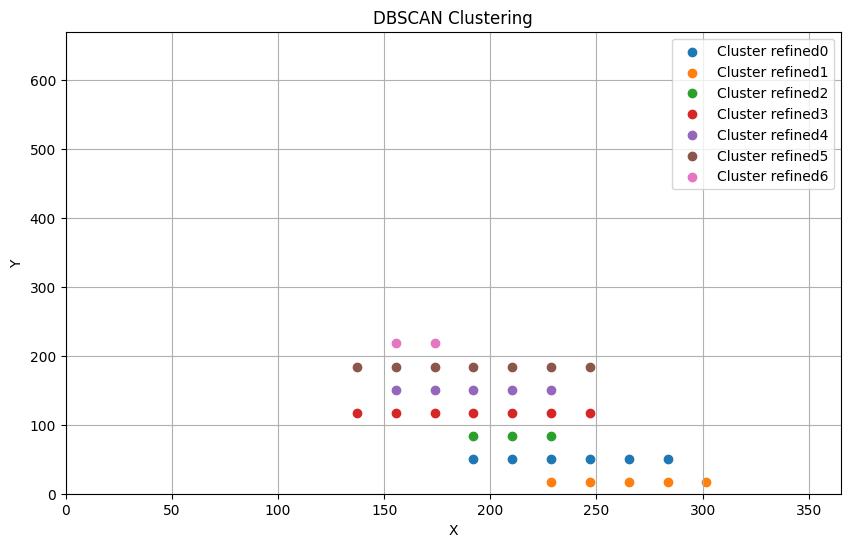

Selected Refined Cluster 1:
(8.930687841141244, 246.88800000000006, 50.292)
(8.930920487955017, 228.60000000000005, 50.292)
(8.933015177042625, 265.17600000000004, 50.292)
(8.933278016462625, 210.31200000000004, 50.292)
(8.934902505720084, 283.46400000000006, 50.292)
(8.947650672680025, 192.02400000000006, 50.292)

Selected Refined Cluster 2:
(8.933639809995055, 246.88800000000006, 16.764)
(8.934490213883535, 265.17600000000004, 16.764)
(8.936837582761962, 283.46400000000006, 16.764)
(8.937668464641087, 301.75200000000007, 16.764)
(8.938657291453264, 228.60000000000005, 16.764)

Selected Refined Cluster 3:
(8.933872956997904, 210.31200000000004, 83.82000000000001)
(8.934549248226707, 228.60000000000005, 83.82000000000001)
(8.94213894193528, 192.02400000000006, 83.82000000000001)

Selected Refined Cluster 4:
(8.938498548612978, 210.31200000000004, 117.34800000000001)
(8.939073436524053, 228.60000000000005, 117.34800000000001)
(8.939776305069302, 192.02400000000006, 117.34800000000001)
(

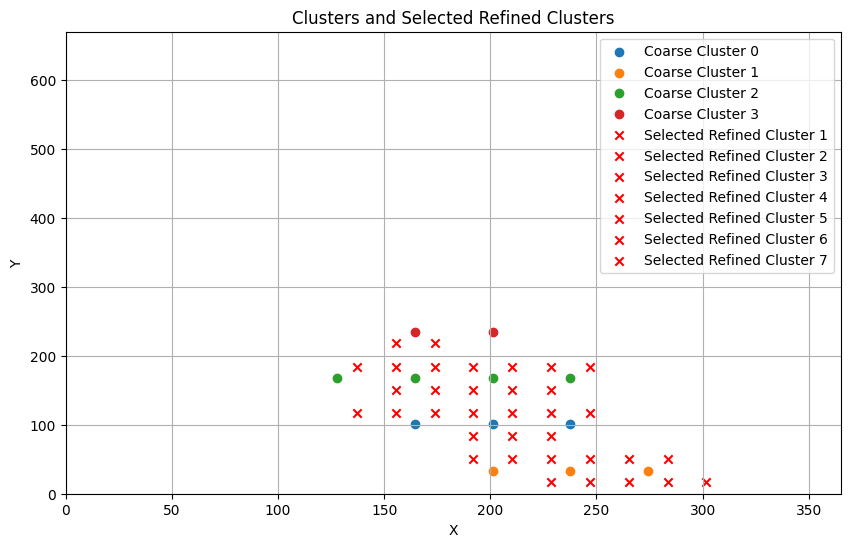

List of tuples (p, x, y) for selected_refined_clusters:
(8.930687841141244, 246.88800000000006, 50.292)
(8.930920487955017, 228.60000000000005, 50.292)
(8.933015177042625, 265.17600000000004, 50.292)
(8.933278016462625, 210.31200000000004, 50.292)
(8.934902505720084, 283.46400000000006, 50.292)
(8.947650672680025, 192.02400000000006, 50.292)
(8.933639809995055, 246.88800000000006, 16.764)
(8.934490213883535, 265.17600000000004, 16.764)
(8.936837582761962, 283.46400000000006, 16.764)
(8.937668464641087, 301.75200000000007, 16.764)
(8.938657291453264, 228.60000000000005, 16.764)
(8.933872956997904, 210.31200000000004, 83.82000000000001)
(8.934549248226707, 228.60000000000005, 83.82000000000001)
(8.94213894193528, 192.02400000000006, 83.82000000000001)
(8.938498548612978, 210.31200000000004, 117.34800000000001)
(8.939073436524053, 228.60000000000005, 117.34800000000001)
(8.939776305069302, 192.02400000000006, 117.34800000000001)
(8.941839726099872, 173.73600000000005, 117.34800000000001)


2024-05-28 17:21:05,928	INFO worker.py:1749 -- Started a local Ray instance.


best coarse is [265.17600000000004, 50.292]
best fine is [271.27200000000005, 41.14800000000001]


2024-05-28 17:28:08,974	INFO worker.py:1749 -- Started a local Ray instance.


best angle is [295.656, 10.668]


In [89]:
selected_layers = 71
sd_coarse_100, result_100 = Checkpoint1_solution(selected_layers, None, 100)
sd_coarse_400, result_400 = Checkpoint1_solution(selected_layers, None, 400)
best = checkpoint2_solution(selected_layers, None)



In [90]:

""" # Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print("Elapsed time:", elapsed_time, "seconds") """

' # Record the end time\nend_time = time.time()\n\n# Calculate the elapsed time\nelapsed_time = end_time - start_time\n\n# Print the elapsed time\nprint("Elapsed time:", elapsed_time, "seconds") '

In [91]:
print(best)

[271.27200000000005, 41.14800000000001]
